https://www.kaggle.com/datasets/mahmoudelhemaly/students-grading-dataset

# Student Performance & Behavior Dataset
Malcolm Bailey

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans

## Introduction

For this unsupervised learning project, I found an interesting dataset on kaggle called "Student Performance & Behavior Dataset" found [here](https://www.kaggle.com/datasets/mahmoudelhemaly/students-grading-dataset). A brief summary is provided from the website here:
>This dataset is real data of 5,000 records collected from a private learning provider.
The dataset includes key attributes necessary for exploring patterns, correlations, and insights related to academic performance.

Education is obviously a very important pillar in modern society, and understanding how to make sure that students get the most out of it is something I'm passionate about. With that in mind, I wanted to analyze what sort of factors impact student performance, and understand various dimensions of students so that we could theorize new ways to help those who are struggling. With that in mind, I want to use clustering methods we've learned in this class along with dimensions reduction methods to observe various types of students and how we can group them.

## Load Data

In [2]:
df_raw = pd.read_csv('Data/Students_Grading_Dataset.csv')
df_raw.head()

Student_ID First_Name Last_Name                    Email  Gender  Age  \
0      S1000       Omar  Williams  student0@university.com  Female   22   
1      S1001      Maria     Brown  student1@university.com    Male   18   
2      S1002      Ahmed     Jones  student2@university.com    Male   24   
3      S1003       Omar  Williams  student3@university.com  Female   24   
4      S1004       John     Smith  student4@university.com  Female   23   

    Department  Attendance (%)  Midterm_Score  Final_Score  ...  \
0  Engineering           52.29          55.03        57.82  ...   
1  Engineering           97.27          97.23        45.80  ...   
2     Business           57.19          67.05        93.68  ...   
3  Mathematics           95.15          47.79        80.63  ...   
4           CS           54.18          46.59        78.89  ...   

   Projects_Score  Total_Score  Grade  Study_Hours_per_Week  \
0           85.90        56.09      F                   6.2   
1           55.65        50.64      A                  19.0   
2           73.79        70.30      D                  20.7   
3           92.12        61.63      A                  24.8   
4           68.42        66.13      F                  15.4   

   Extracurricular_Activities Internet_Access_at_Home  Parent_Education_Level  \
0                          No                     Yes             High School   
1                          No                     Yes                     NaN   
2                          No                     Yes                Master's   
3                         Yes                     Yes             High School   
4                         Yes                     Yes             High School   

  Family_Income_Level Stress_Level (1-10) Sleep_Hours_per_Night  
0              Medium                   5                   4.7  
1              Medium                   4                   9.0  
2                 Low                   6                   6.2  
3                High                   3                   6.7  
4                High                   2                   7.1  

[5 rows x 23 columns]

In [3]:
df_raw['Family_Income_Level'].unique()

array(['Medium', 'Low', 'High'], dtype=object)

In [4]:
print(df_raw.columns)
print(df_raw.dtypes)

Index(['Student_ID', 'First_Name', 'Last_Name', 'Email', 'Gender', 'Age',
       'Department', 'Attendance (%)', 'Midterm_Score', 'Final_Score',
       'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
       'Projects_Score', 'Total_Score', 'Grade', 'Study_Hours_per_Week',
       'Extracurricular_Activities', 'Internet_Access_at_Home',
       'Parent_Education_Level', 'Family_Income_Level', 'Stress_Level (1-10)',
       'Sleep_Hours_per_Night'],
      dtype='object')
Student_ID                     object
First_Name                     object
Last_Name                      object
Email                          object
Gender                         object
Age                             int64
Department                     object
Attendance (%)                float64
Midterm_Score                 float64
Final_Score                   float64
Assignments_Avg               float64
Quizzes_Avg                   float64
Participation_Score           float64
Projects_Score            

### What Data Do We Have?
Most of these columns are self explanatory, but I'll add a few details here or there that I felt were missing.
- Gender (two values, Male or Female)
- Department: four values (Engineering, Business, Mathematics, CS)
- Parent_Education_Level: four values (High School, nan, Master's, PhD, Bachelor's)
- Family_Income_Level: three values (Low, Medium, High)

## EDA and Data Preprocessing

First thing to note is that we can drop identifying information such as names and emails

In [5]:
df = df_raw.drop(['Student_ID', 'First_Name', 'Last_Name', 'Email'], axis = 1)

In [6]:
print("Data shape is {}".format(df.shape))
df.head()

Data shape is (5000, 19)


Gender  Age   Department  Attendance (%)  Midterm_Score  Final_Score  \
0  Female   22  Engineering           52.29          55.03        57.82   
1    Male   18  Engineering           97.27          97.23        45.80   
2    Male   24     Business           57.19          67.05        93.68   
3  Female   24  Mathematics           95.15          47.79        80.63   
4  Female   23           CS           54.18          46.59        78.89   

   Assignments_Avg  Quizzes_Avg  Participation_Score  Projects_Score  \
0            84.22        74.06                 3.99           85.90   
1              NaN        94.24                 8.32           55.65   
2            67.70        85.70                 5.05           73.79   
3            66.06        93.51                 6.54           92.12   
4            96.85        83.70                 5.97           68.42   

   Total_Score Grade  Study_Hours_per_Week Extracurricular_Activities  \
0        56.09     F                   6.2                         No   
1        50.64     A                  19.0                         No   
2        70.30     D                  20.7                         No   
3        61.63     A                  24.8                        Yes   
4        66.13     F                  15.4                        Yes   

  Internet_Access_at_Home Parent_Education_Level Family_Income_Level  \
0                     Yes            High School              Medium   
1                     Yes                    NaN              Medium   
2                     Yes               Master's                 Low   
3                     Yes            High School                High   
4                     Yes            High School                High   

   Stress_Level (1-10)  Sleep_Hours_per_Night  
0                    5                    4.7  
1                    4                    9.0  
2                    6                    6.2  
3                    3                    6.7  
4                    2                    7.1

After dropping irrelevant columns, I want to make sure the data is clean (no missing values, suspicious outliers, etc.). If there is an outlier, we'll also need to figure out how to deal with it.

In [7]:
for col in df.columns:
    nancount = np.sum(df[col].isna())
    if nancount > 0:
        print(f"Column {col} has {nancount} nan values")

Column Attendance (%) has 516 nan values
Column Assignments_Avg has 517 nan values
Column Parent_Education_Level has 1794 nan values


As we can see, there's a significant amount of nan values in a few specific columns:
- Attendance
- Assignments_Avg
- Parent_Education_Level

Unfortunately, I think that having 1794 missing values on a dataset of 5000 rows is a bit excessive and as a result I'll drop that column, as that's nearly 40% of the data missing for that column. The other two rows are closer to 10% data missing, so I intend to still utilize those two columns.

As far as managing these two columns goes, the three main options are:
- drop these rows
- make them 0
- make them the average of that column

I first read about these measurements a bit, and I decided that it makes sense to make Attendance averager, so that they don't stand out in either direction.

For assignments average, I realized that it's most likely calculable bny taking their scores across everything in conjunction with the total score and reverse solving it.

In [8]:
df.drop('Parent_Education_Level', axis = 1, inplace=True)
df['Attendance (%)'] = df['Attendance (%)'].fillna(df['Attendance (%)'].mean())

At this point I realized some weird data scenarios that I mentioned on the original dataset's discussion page. For example, how can a student with a total score of 61.63 have a grade of A. Since there's some disconnect between their overall performance and the grade they receive, I think dropping the grade makes sense as well.

In [9]:
df.drop('Grade', axis = 1, inplace=True)

In [10]:
# Checking how the other scores could add up to total score by looking at the average of those scores for a couple rows
only_scores = df[['Midterm_Score',
                    'Final_Score',
                    'Assignments_Avg',
                    'Quizzes_Avg',
                    'Participation_Score',
                    'Projects_Score',
                    'Total_Score']].copy()
# for now drop nans from assignments avg, as that'll be enough to still find the relationship
only_scores.dropna(axis=0, inplace=True)

In [11]:
# do linear regression to see how those score columns relate to total_score
lr = LinearRegression().fit(only_scores.drop('Total_Score', axis = 1), only_scores['Total_Score'])

In [12]:
print(lr.coef_)
print(lr.n_features_in_)
print(lr.score(only_scores.drop('Total_Score', axis = 1), only_scores['Total_Score']))

[-0.00040674  0.00395919  0.00102515  0.01185471 -0.16257167 -0.01795492]
6
0.0015320293563614307


These results from linear regression are **extremely** surprising, essentially it's indicating that the Total_Score captured here is not a linear combination of the other score columns, which I would certainly expect it to be. Regardless, we press on! (but we do keep this in mind)

So we've learned we probably can't easily recreate the assignment_avg values by reverse engineering the total_score (since it seems like the relationship between these columns is non-linear and strange), so instead we'll set them as the mean

In [13]:
df['Assignments_Avg'] = df['Assignments_Avg'].fillna(df['Assignments_Avg'].mean())

In [14]:
df.head()

Gender  Age   Department  Attendance (%)  Midterm_Score  Final_Score  \
0  Female   22  Engineering           52.29          55.03        57.82   
1    Male   18  Engineering           97.27          97.23        45.80   
2    Male   24     Business           57.19          67.05        93.68   
3  Female   24  Mathematics           95.15          47.79        80.63   
4  Female   23           CS           54.18          46.59        78.89   

   Assignments_Avg  Quizzes_Avg  Participation_Score  Projects_Score  \
0        84.220000        74.06                 3.99           85.90   
1        74.798673        94.24                 8.32           55.65   
2        67.700000        85.70                 5.05           73.79   
3        66.060000        93.51                 6.54           92.12   
4        96.850000        83.70                 5.97           68.42   

   Total_Score  Study_Hours_per_Week Extracurricular_Activities  \
0        56.09                   6.2                         No   
1        50.64                  19.0                         No   
2        70.30                  20.7                         No   
3        61.63                  24.8                        Yes   
4        66.13                  15.4                        Yes   

  Internet_Access_at_Home Family_Income_Level  Stress_Level (1-10)  \
0                     Yes              Medium                    5   
1                     Yes              Medium                    4   
2                     Yes                 Low                    6   
3                     Yes                High                    3   
4                     Yes                High                    2   

   Sleep_Hours_per_Night  
0                    4.7  
1                    9.0  
2                    6.2  
3                    6.7  
4                    7.1

In [15]:
df['Family_Income_Level'].unique()

array(['Medium', 'Low', 'High'], dtype=object)

#### Making things quantitative
- Gender: 0 for Male, 1 for Female
- Department: one-hot encoding
- Extracurricular_Activities: 0 for No, 1 for Yes
- Internet_Access_at_Home: 0 for No, 1 for Yes
- Family_Income_Level: 1 for low, 2 for medium, 3 for high

In [16]:
# fix department
df = df.join(pd.get_dummies(df['Department']), how='inner')
df.drop('Department', axis=1, inplace=True)

In [17]:
remapping_dict = {
    "Gender": {'Female': 1, 'Male': 0},
    "Extracurricular_Activities": {"Yes": 1, "No": 0},
    "Internet_Access_at_Home": {"Yes": 1, "No": 0},
    "Family_Income_Level": {"Low": 1, "Medium": 2, "High": 3}
}
for col in remapping_dict.keys():
    df[col] = df[col].map(lambda x: remapping_dict[col][x])

In [18]:
df.head()

Gender  Age  Attendance (%)  Midterm_Score  Final_Score  Assignments_Avg  \
0       1   22           52.29          55.03        57.82        84.220000   
1       0   18           97.27          97.23        45.80        74.798673   
2       0   24           57.19          67.05        93.68        67.700000   
3       1   24           95.15          47.79        80.63        66.060000   
4       1   23           54.18          46.59        78.89        96.850000   

   Quizzes_Avg  Participation_Score  Projects_Score  Total_Score  \
0        74.06                 3.99           85.90        56.09   
1        94.24                 8.32           55.65        50.64   
2        85.70                 5.05           73.79        70.30   
3        93.51                 6.54           92.12        61.63   
4        83.70                 5.97           68.42        66.13   

   Study_Hours_per_Week  Extracurricular_Activities  Internet_Access_at_Home  \
0                   6.2                           0                        1   
1                  19.0                           0                        1   
2                  20.7                           0                        1   
3                  24.8                           1                        1   
4                  15.4                           1                        1   

   Family_Income_Level  Stress_Level (1-10)  Sleep_Hours_per_Night  Business  \
0                    2                    5                    4.7     False   
1                    2                    4                    9.0     False   
2                    1                    6                    6.2      True   
3                    3                    3                    6.7     False   
4                    3                    2                    7.1     False   

      CS  Engineering  Mathematics  
0  False         True        False  
1  False         True        False  
2  False        False        False  
3  False        False         True  
4   True        False        False

### Correlation Analysis

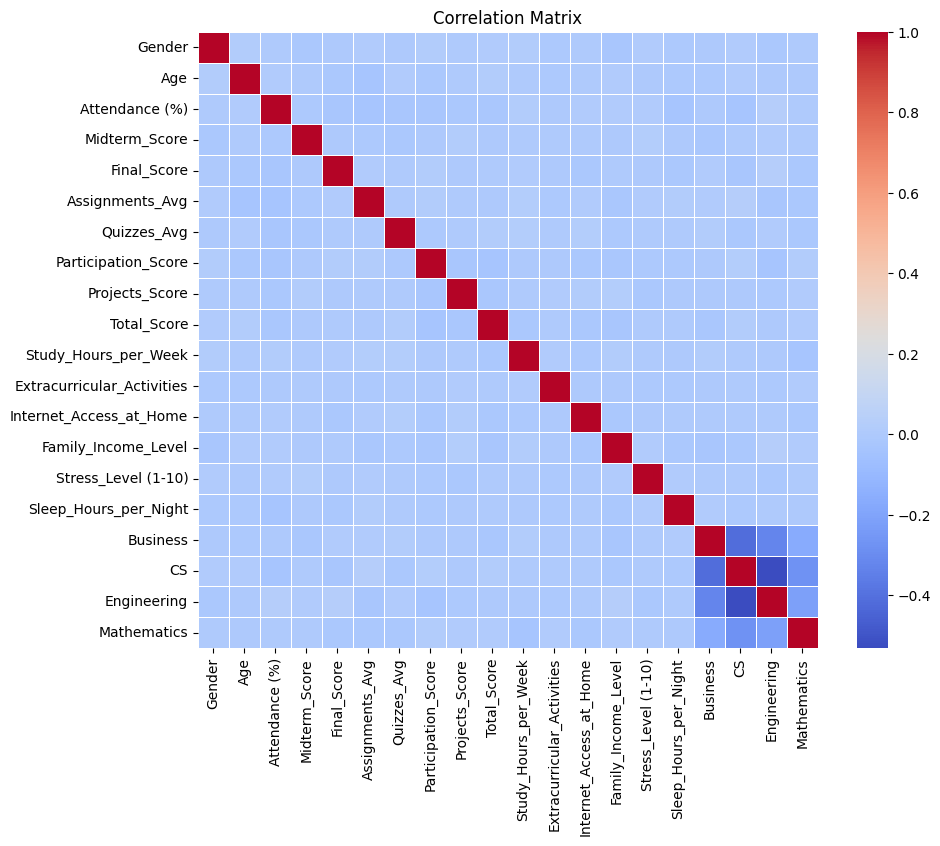

In [19]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

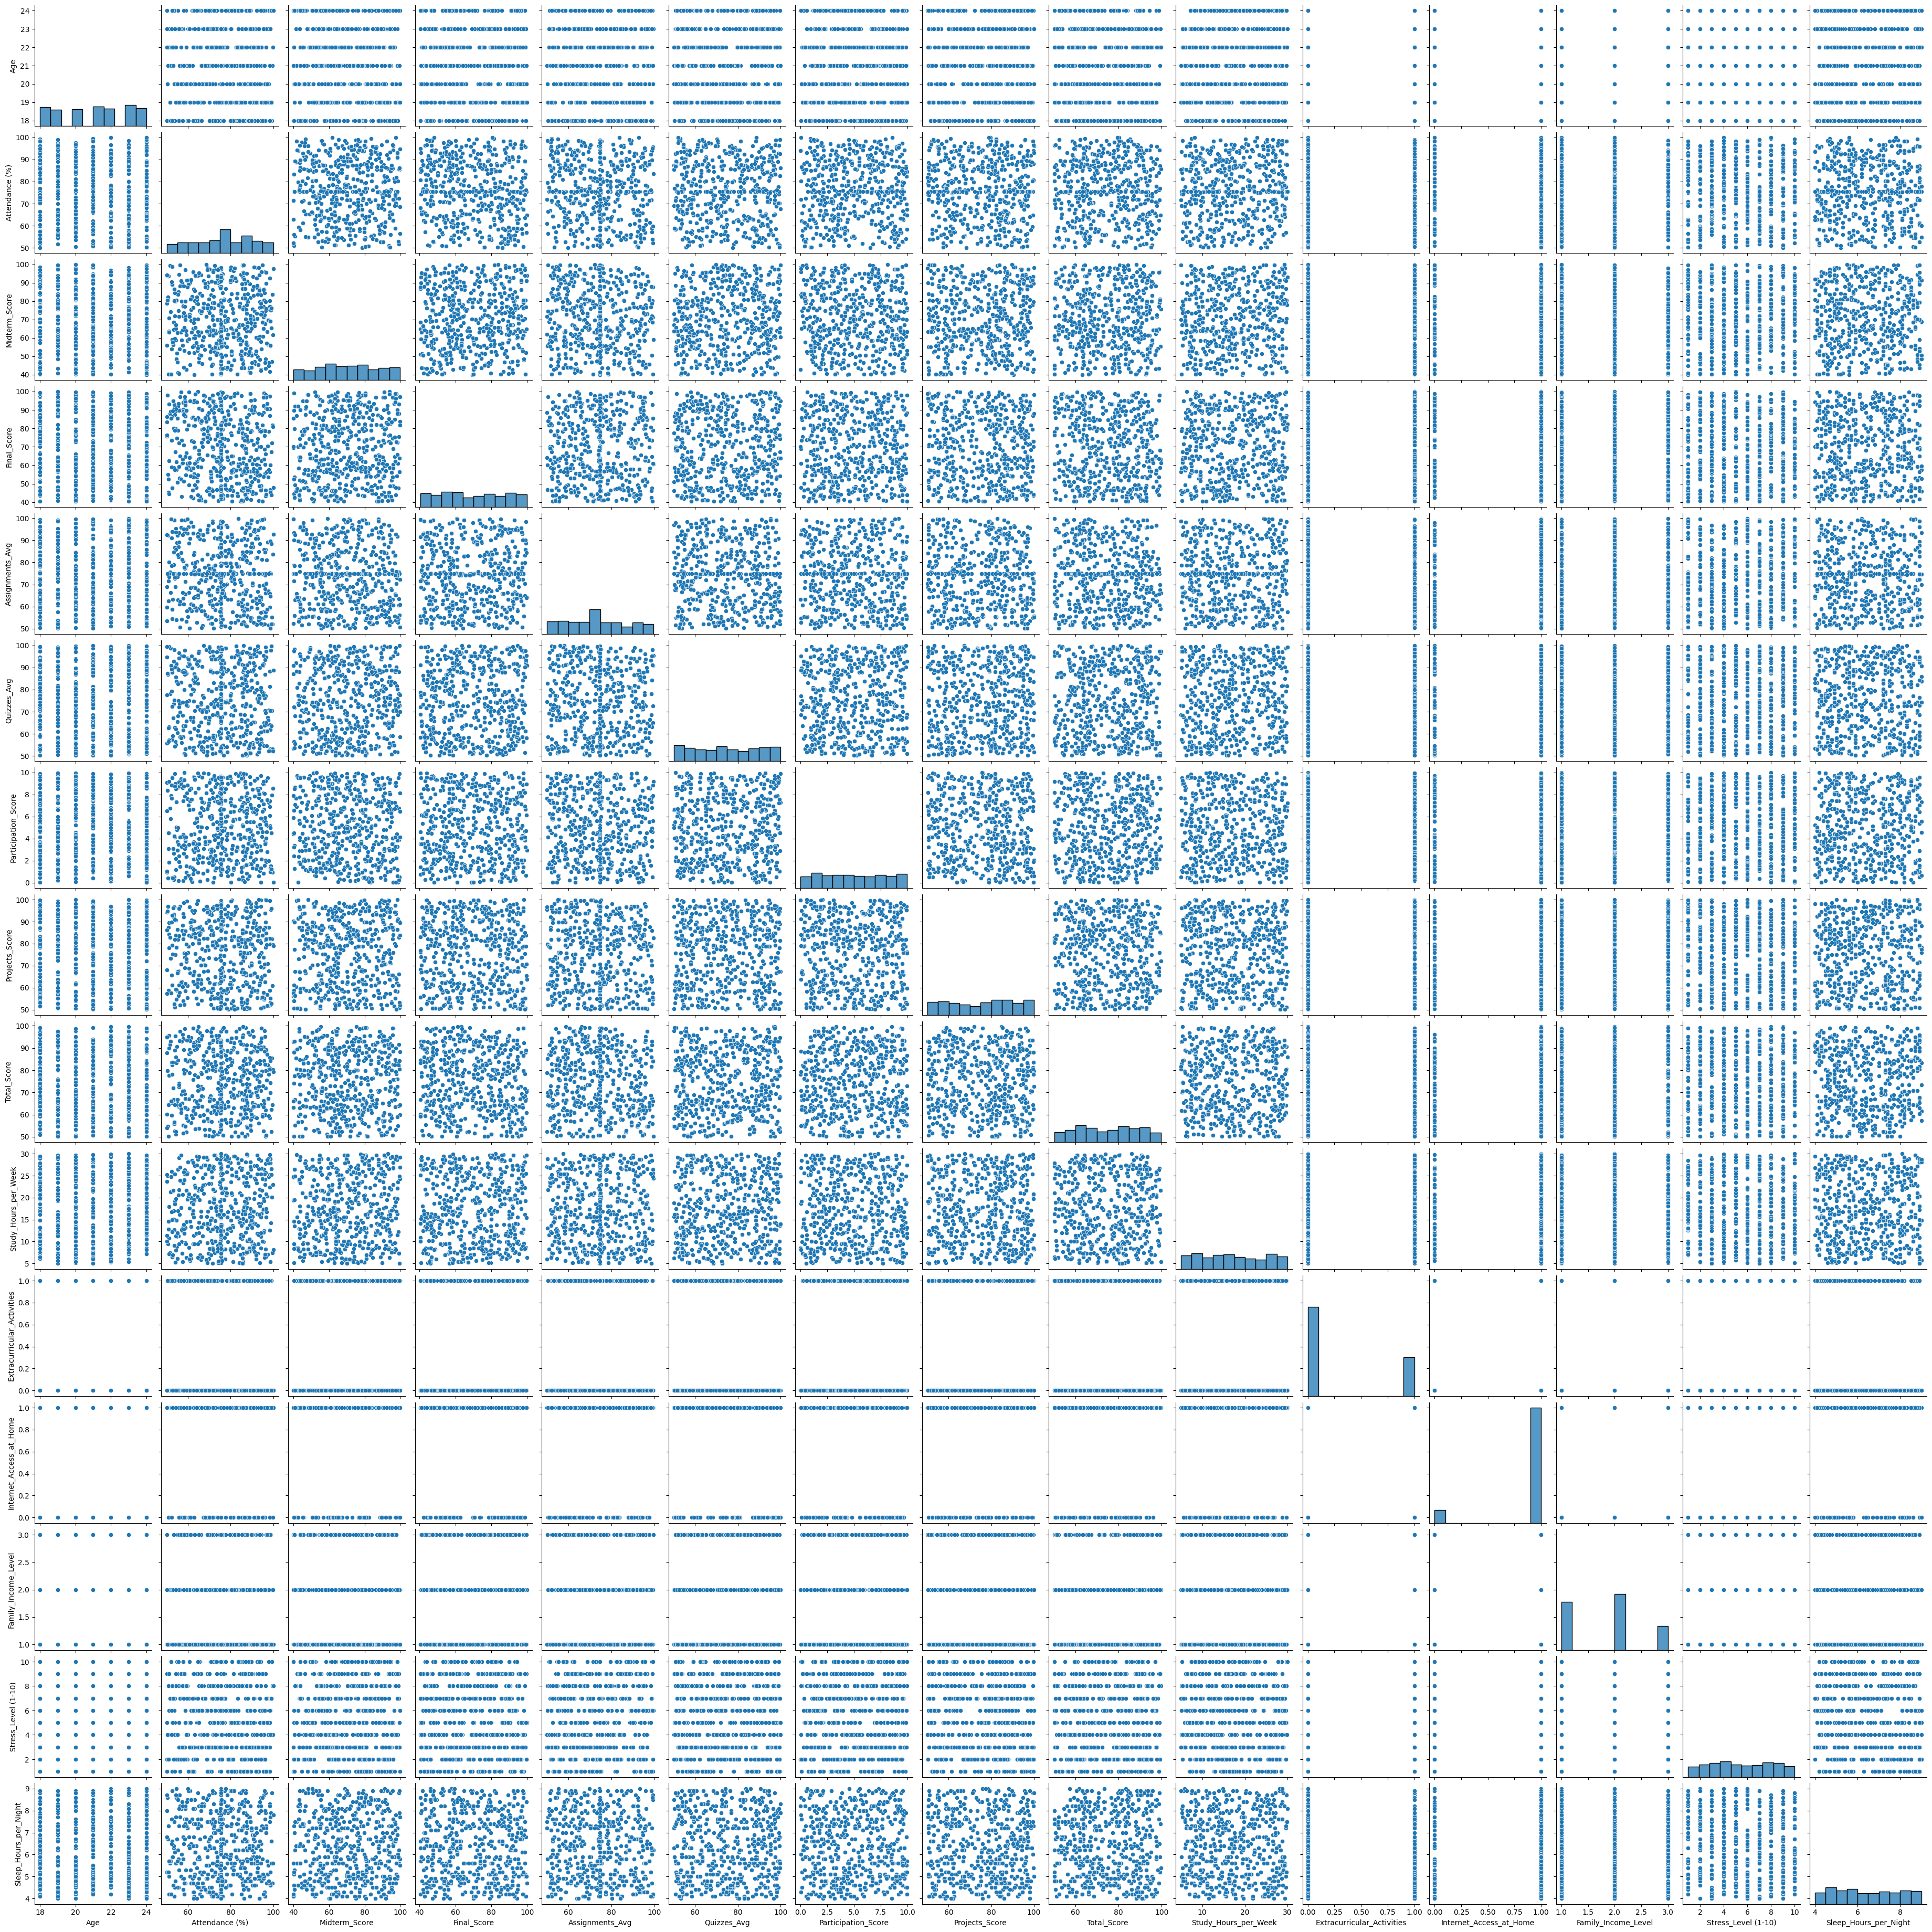

In [20]:
sns.pairplot(df.iloc[:,1:-4].sample(500))

That's some uncorrelated data if I've ever seen uncorrelated data! (Some would rightly point out that it's *suspiciously* uncorrelated.)

In [21]:
df.describe()

Gender          Age  Attendance (%)  Midterm_Score  Final_Score  \
count  5000.000000  5000.000000     5000.000000    5000.000000  5000.000000   
mean      0.489800    21.048400       75.431409      70.326844    69.640788   
std       0.499946     1.989786       13.610481      17.213209    17.238744   
min       0.000000    18.000000       50.010000      40.000000    40.000000   
25%       0.000000    19.000000       64.737500      55.457500    54.667500   
50%       0.000000    21.000000       75.431409      70.510000    69.735000   
75%       1.000000    23.000000       86.182500      84.970000    84.500000   
max       1.000000    24.000000      100.000000      99.980000    99.980000   

       Assignments_Avg  Quizzes_Avg  Participation_Score  Projects_Score  \
count      5000.000000  5000.000000          5000.000000     5000.000000   
mean         74.798673    74.910728             4.980024       74.924860   
std          13.646226    14.504281             2.890136       14.423415   
min          50.000000    50.030000             0.000000       50.010000   
25%          63.687500    62.490000             2.440000       62.320000   
50%          74.798673    74.695000             4.955000       74.980000   
75%          85.570000    87.630000             7.500000       87.367500   
max          99.980000    99.960000            10.000000      100.000000   

       Total_Score  Study_Hours_per_Week  Extracurricular_Activities  \
count  5000.000000           5000.000000                 5000.000000   
mean     75.121804             17.658860                    0.301400   
std      14.399941              7.275864                    0.458912   
min      50.020000              5.000000                    0.000000   
25%      62.835000             11.400000                    0.000000   
50%      75.395000             17.500000                    0.000000   
75%      87.652500             24.100000                    1.000000   
max      99.990000             30.000000                    1.000000   

       Internet_Access_at_Home  Family_Income_Level  Stress_Level (1-10)  \
count              5000.000000          5000.000000           5000.00000   
mean                  0.897000             1.812200              5.48080   
std                   0.303989             0.755146              2.86155   
min                   0.000000             1.000000              1.00000   
25%                   1.000000             1.000000              3.00000   
50%                   1.000000             2.000000              5.00000   
75%                   1.000000             2.000000              8.00000   
max                   1.000000             3.000000             10.00000   

       Sleep_Hours_per_Night  
count            5000.000000  
mean                6.488140  
std                 1.452283  
min                 4.000000  
25%                 5.200000  
50%                 6.500000  
75%                 7.700000  
max                 9.000000

No outliers or suspicious values here, we see a nice gender distribution and all of the means look pretty reasonable as well as the 25 and 75 percent quartiles.

#### Normalizing Data
Kmeans clustering and non-negative matrix factorization(NMF) are very sensitive to the magnitude of data, so we want to make sure everything is on a similar 0 to 1 scale.

In [22]:
df.columns

Index(['Gender', 'Age', 'Attendance (%)', 'Midterm_Score', 'Final_Score',
       'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
       'Projects_Score', 'Total_Score', 'Study_Hours_per_Week',
       'Extracurricular_Activities', 'Internet_Access_at_Home',
       'Family_Income_Level', 'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Business', 'CS', 'Engineering', 'Mathematics'],
      dtype='object')

In [23]:
#normalize all columns here
columns_to_normalize = ['Age', 'Attendance (%)', 'Midterm_Score', 'Final_Score',
       'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
       'Projects_Score', 'Total_Score', 'Study_Hours_per_Week',
       'Extracurricular_Activities', 'Internet_Access_at_Home',
       'Family_Income_Level', 'Stress_Level (1-10)', 'Sleep_Hours_per_Night']

def normalize_column(df, columns_to_normalize):
    normalized_df = df.copy()
    for col in columns_to_normalize:
        normalized_df[col] = (df[col] - np.min(df[col])) / (np.max(df[col]) - np.min(df[col]))
    return normalized_df

df_preprocessed = normalize_column(df, columns_to_normalize)

In [24]:
df_preprocessed.describe()

Gender          Age  Attendance (%)  Midterm_Score  Final_Score  \
count  5000.000000  5000.000000     5000.000000    5000.000000  5000.000000   
mean      0.489800     0.508067        0.508530       0.505616     0.494178   
std       0.499946     0.331631        0.272264       0.286982     0.287408   
min       0.000000     0.000000        0.000000       0.000000     0.000000   
25%       0.000000     0.166667        0.294609       0.257711     0.244540   
50%       0.000000     0.500000        0.508530       0.508670     0.495749   
75%       1.000000     0.833333        0.723595       0.749750     0.741914   
max       1.000000     1.000000        1.000000       1.000000     1.000000   

       Assignments_Avg  Quizzes_Avg  Participation_Score  Projects_Score  \
count      5000.000000  5000.000000          5000.000000     5000.000000   
mean          0.496172     0.498312             0.498002        0.498397   
std           0.273034     0.290492             0.289014        0.288526   
min           0.000000     0.000000             0.000000        0.000000   
25%           0.273860     0.249549             0.244000        0.246249   
50%           0.496172     0.493992             0.495500        0.499500   
75%           0.711685     0.753054             0.750000        0.747299   
max           1.000000     1.000000             1.000000        1.000000   

       Total_Score  Study_Hours_per_Week  Extracurricular_Activities  \
count  5000.000000           5000.000000                 5000.000000   
mean      0.502337              0.506354                    0.301400   
std       0.288172              0.291035                    0.458912   
min       0.000000              0.000000                    0.000000   
25%       0.256454              0.256000                    0.000000   
50%       0.507805              0.500000                    0.000000   
75%       0.753102              0.764000                    1.000000   
max       1.000000              1.000000                    1.000000   

       Internet_Access_at_Home  Family_Income_Level  Stress_Level (1-10)  \
count              5000.000000          5000.000000          5000.000000   
mean                  0.897000             0.406100             0.497867   
std                   0.303989             0.377573             0.317950   
min                   0.000000             0.000000             0.000000   
25%                   1.000000             0.000000             0.222222   
50%                   1.000000             0.500000             0.444444   
75%                   1.000000             0.500000             0.777778   
max                   1.000000             1.000000             1.000000   

       Sleep_Hours_per_Night  
count            5000.000000  
mean                0.497628  
std                 0.290457  
min                 0.000000  
25%                 0.240000  
50%                 0.500000  
75%                 0.740000  
max                 1.000000

## Investigating Student Performance, Sleep, and Stress:
For this project, I wanted to investigate the relationship between stress, sleep, and performance. In order to do this, I needed to drop some columns (which helps with visualization and clustering, as it counteracts the curse of dimensionality).

In [25]:
df_sleep_stress_scores = df_preprocessed.drop(['Family_Income_Level',
                                  'Business', 'CS', 
                                  'Engineering', 'Mathematics',
                                  'Internet_Access_at_Home', 
                                  'Participation_Score',
                                  'Attendance (%)', 'Gender',
                                  'Age', 'Assignments_Avg',
                                  'Quizzes_Avg', 'Projects_Score',
                                  'Study_Hours_per_Week', 'Extracurricular_Activities'], axis = 1)
                                  

In [26]:
df_sleep_stress_scores.describe()

Midterm_Score  Final_Score  Total_Score  Stress_Level (1-10)  \
count    5000.000000  5000.000000  5000.000000          5000.000000   
mean        0.505616     0.494178     0.502337             0.497867   
std         0.286982     0.287408     0.288172             0.317950   
min         0.000000     0.000000     0.000000             0.000000   
25%         0.257711     0.244540     0.256454             0.222222   
50%         0.508670     0.495749     0.507805             0.444444   
75%         0.749750     0.741914     0.753102             0.777778   
max         1.000000     1.000000     1.000000             1.000000   

       Sleep_Hours_per_Night  
count            5000.000000  
mean                0.497628  
std                 0.290457  
min                 0.000000  
25%                 0.240000  
50%                 0.500000  
75%                 0.740000  
max                 1.000000

#### KMeans on the Original Data

In [27]:
clf_list = []
for n in range(2,30):
    clf = KMeans(n_clusters=n)
    clf.fit(df_sleep_stress_scores)
    clf_list.append([clf, n, clf.inertia_])

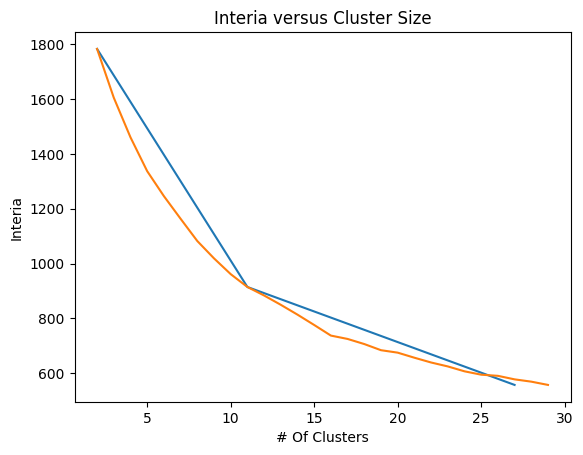

In [28]:
clf_cluster_list = np.array(clf_list)
plt.title("Interia versus Cluster Size")
plt.ylabel("Interia")
plt.xlabel("# Of Clusters")
plt.plot([2,11,27], [clf_cluster_list[0,2], clf_cluster_list[9,2], clf_cluster_list[27,2]])
plt.plot(clf_cluster_list[:,1], clf_cluster_list[:,2])

Looks like there's an elbow point around 10 clusters when I perform KMeans on the original group. I will investigate what these 10 groups look like by coloring them based on cluster and trying to visualize it (even with all of the features). With that being said, even at 50 clusters, we're still seeing a fairly high inertia here.

In [29]:
kmean_clf = clf_list[9][0]
df_clustered = df_sleep_stress_scores.copy()
df_clustered['kmeans_cluster'] = kmean_clf.predict(df_sleep_stress_scores)

Given the huge number of features and their rather uniform distributions, it's clear that the clustering on the original features isn't very insightful. That's why we'll bring in NME to try and find some simpler representations.

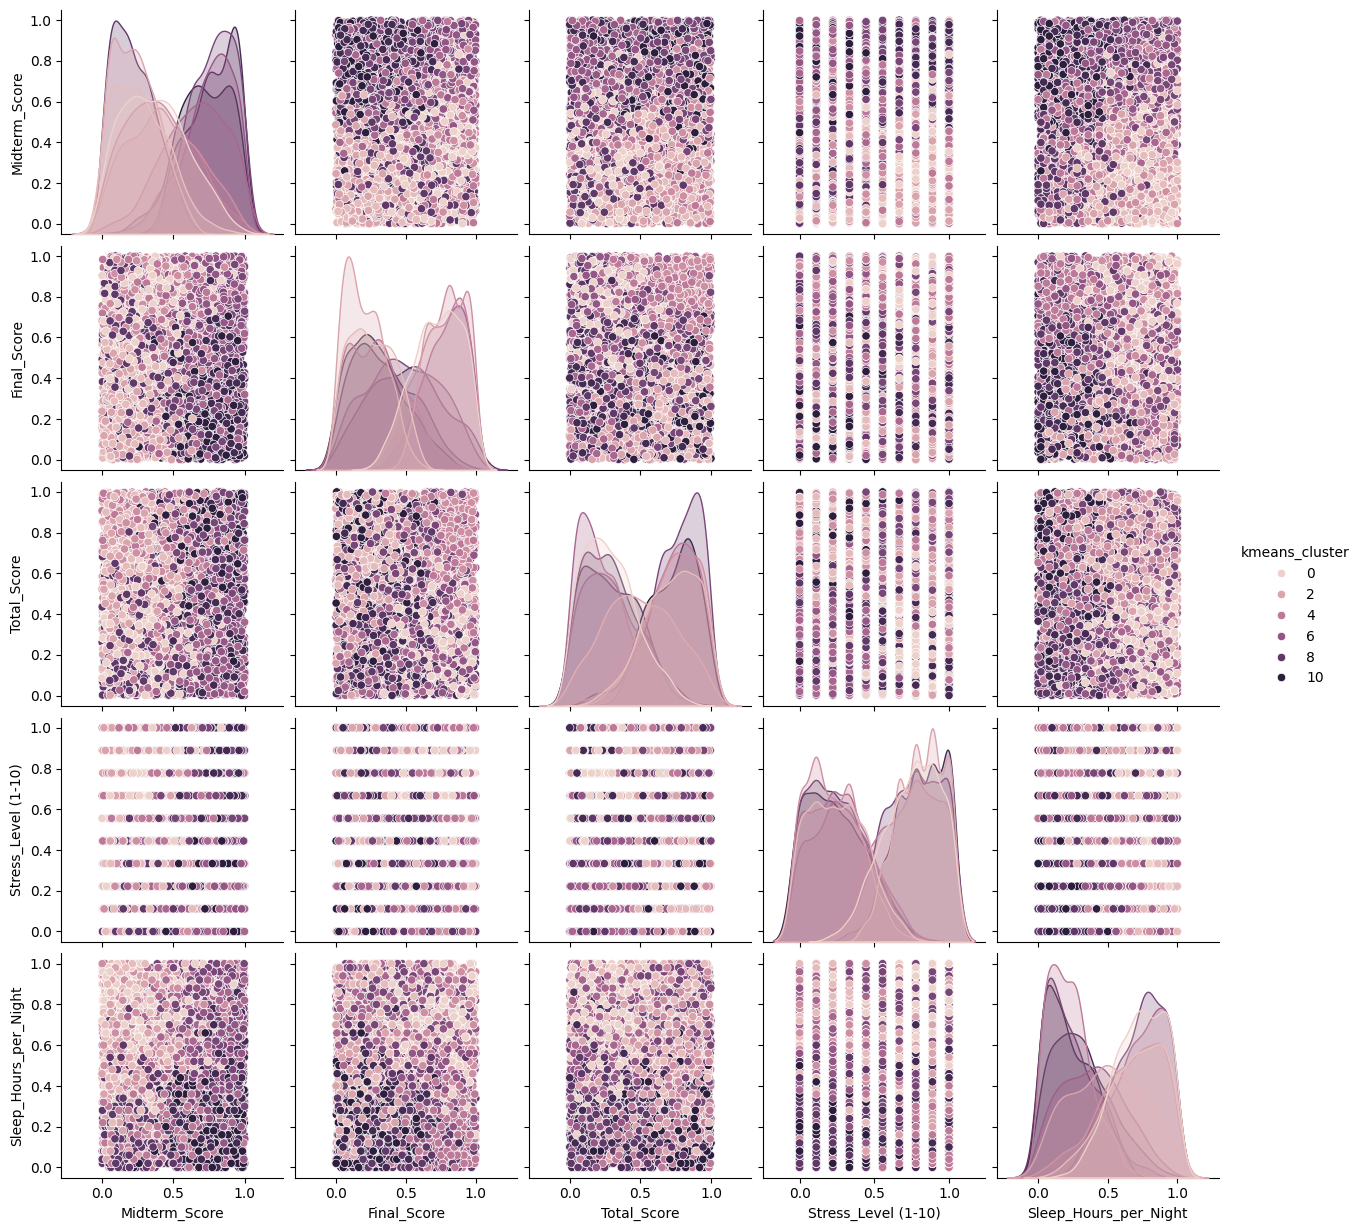

In [30]:
sns.pairplot(df_clustered, hue='kmeans_cluster')

#### Non-negative Matrix Factorization on the Original Data

Since our data is non-negative, we can use non-negative matrix factorization to potentially reduce our data into lower dimensions that allow cleaner grouping with a bonus of easily interpretable components. Since I view the data we're working with in 3 lenses, I'm hoping that picking 3 components finds a similar lens for our data.

In [31]:
n = 3
nmf = NMF(n_components = n, max_iter = 400).fit(df_sleep_stress_scores)
W = nmf.transform(df_sleep_stress_scores)
h = nmf.components_

In [32]:
def print_important_columns(h):
    comp_1 = []
    comp_2 =[]
    comp_3 = []
    important_threshold = 1.5
          
    for i, column in enumerate(df_sleep_stress_scores.columns):
        if h[0][i] > important_threshold:
            comp_1.append(column)
        if h[1][i] > important_threshold:
            comp_2.append(column) 
        if nmf.n_components_ == 3:
            if h[2][i] > important_threshold:
                comp_3.append(column) 

    print("Import columns for component 1 {}".format(comp_1))
    print("Import columns for component 2 {}".format(comp_2))
    print("Import columns for component 3 {}".format(comp_3))
            
print_important_columns(h)

Import columns for component 1 ['Midterm_Score', 'Final_Score', 'Total_Score']
Import columns for component 2 ['Stress_Level (1-10)']
Import columns for component 3 ['Sleep_Hours_per_Night']


#### Discussion of NMF
So what we see in this NMF is that the three components are a metric for "performance", a metric for stress, and a metric for sleep. This is great because it allows us to easily interpret the clusters as they land on each of the three axes below.

I also tried two dimensions, but found the groupings were less intuitive, so I'm sticking with 3!

I am going to choose 8 clusters, because I would like to see the 8 different groups formed by the 3 binary groups of good/bad performance, good/bad sleep, and high/low stress

/tmp/ipykernel_3197/3219918616.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(W[cluster_indices, 0], W[cluster_indices, 1], W[cluster_indices, 2],


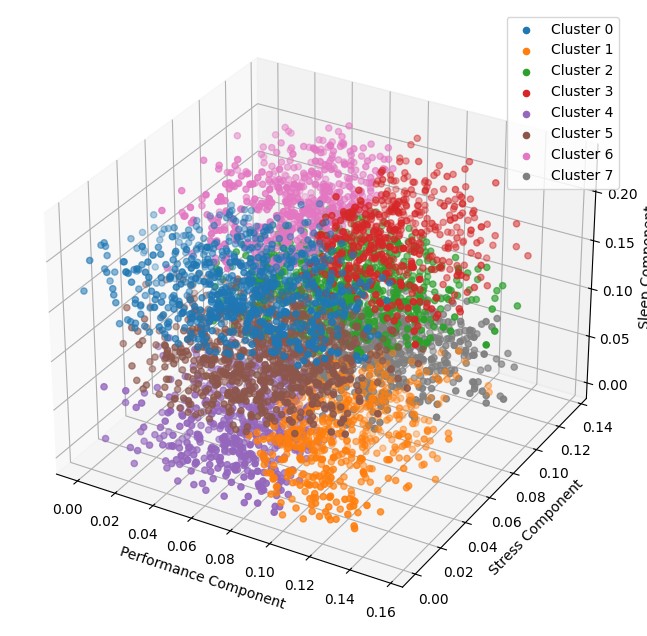

In [33]:
# repeat clustering
n_clusters = 8
clf = KMeans(n_clusters=n_clusters)
clf.fit(W)
clusters = clf.predict(W)
    
if W.shape[1] == 3:
    fig = plt.figure(figsize = [8,8])
    ax = fig.add_subplot(projection='3d')
    for cluster_num in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster_num)[0]
        ax.scatter(W[cluster_indices, 0], W[cluster_indices, 1], W[cluster_indices, 2],
           label=f'Cluster {cluster_num}', cmap='prism')

    ax.set_xlabel('Performance Component')
    ax.set_ylabel('Stress Component')
    ax.set_zlabel('Sleep Component')
    plt.legend()
else:
    fig = plt.figure(figsize = [8,8])
    ax = fig.add_subplot()
    for cluster_num in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster_num)[0]
        plt.scatter(W[cluster_indices, 0], W[cluster_indices, 1],
                    label=f'Cluster {cluster_num}', cmap='prism')
    ax.set_xlabel('Stress Component')
    ax.set_ylabel('Performance/Sleep Component')
plt.legend()


In [34]:
df_sleep_stress_scores_nmf_cluster= pd.DataFrame(W)
df_sleep_stress_scores_nmf_cluster.columns = ['Performance Component', 'Stress Component', 'Sleep Component']

Now that we see these clusters, let's user their cluster and the original data to figure out what sort of groups we might have here.

In [35]:
df_sleep_stress_scores_nmf_cluster['cluster'] = clusters
df_grouped = df_sleep_stress_scores_nmf_cluster.groupby('cluster')
print("Average:{}".format(
    df_grouped[['Performance Component', 'Stress Component', 'Sleep Component']].agg(['mean', 'std']).sort_values(by=('Performance Component', 'mean'))))

Average:        Performance Component           Stress Component            \
                         mean       std             mean       std   
cluster                                                              
6                    0.041678  0.016667         0.097981  0.021464   
4                    0.059113  0.018776         0.029165  0.021120   
0                    0.063967  0.027324         0.026011  0.018628   
2                    0.065401  0.025993         0.099761  0.019726   
5                    0.071387  0.025632         0.029727  0.019566   
7                    0.077918  0.026128         0.103381  0.018563   
3                    0.093414  0.017808         0.095943  0.022478   
1                    0.106920  0.016230         0.037069  0.023551   

        Sleep Component            
                   mean       std  
cluster                            
6              0.173023  0.023699  
4              0.033343  0.021630  
0              0.178117  0.020047  
2    

### Discussion on NMF
So based on the table above, there's some very notable groups. (I've learned the clusters change name, so I have to vaguely reference them.)

#### Low Performers (First Two Clusters)
 These 2 groups have low averages for our performance component, and we see that cluster 7 has rather low sleep and high stress. Cluster 2 on the other hand is low stress and also high sleep. I take these stats to indicate a struggling group of students in cluster 7 and a slacker group of students in cluster 2.
 
#### Moderate Performers (Middle 3)
Within the cluster of moderate performers, we have clsuter 0,5, and 6. Cluster 6 actually takes the crown for highest stress, demonstrating a group that is probably trying very hard to improve, but is not having success. Their sleep is not particulary high or low. Clusters 0 and 5 both do well on sleep, placing in the upper quartile of that metric. Their key difference is stress. Cluster 0 is close to 6 in this regard, while 5 is much less worried. I would say cluster 5 would be a healthy average student, while 0 and 6 are students with different sleep needs but similar performance and aspirations.

### High Performers (Upper 3)
In this group, we see the students with high performance components (quite a coincidence that number 1 is a high achiever!). Looking at the stress column, cluster 4 is a clear standout, as they are NOT okay. If we were trying to help keep our students happy, I would highly advise that cluster 4 was given a pizza party or was given counseling to help them manage stress. They also have low sleep in common with cluster 1, placing in the very lowest quartiles of sleep on average. These cluster 4 students could be flagged for potential burnout, as they are seemingly pushing themselves to their limits. Cluster 1 somehow manages to have low stress, these students either do not need the same level of sleep or they have some hidden knowledge to teach cluster 4 about stress management! Lastly, clsuter 3 seems to be the most potentially capable group of students, as they manage to excel while still sleeping well and managing stress. External factors such as financial stability could be a factor here.

### Visualizing the clusters

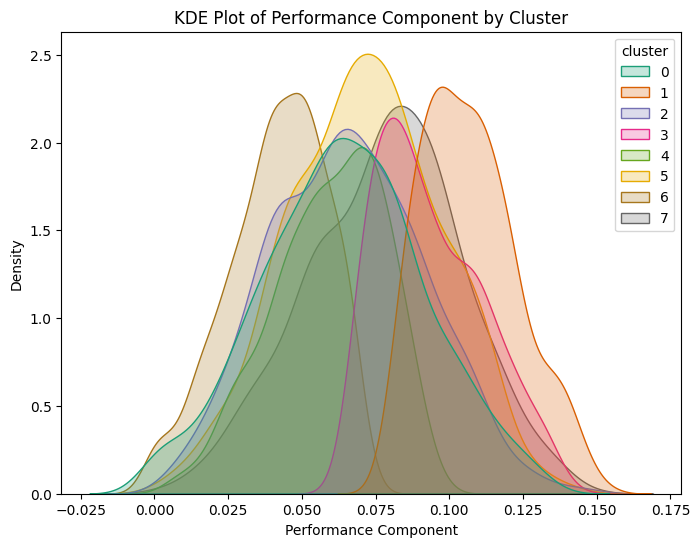

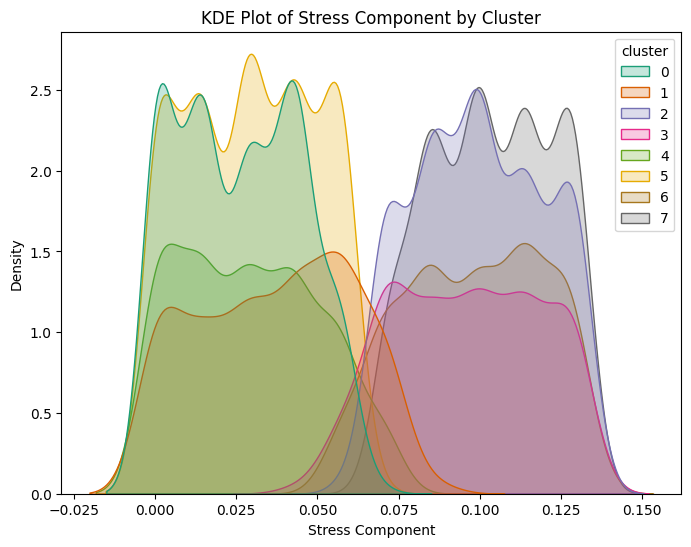

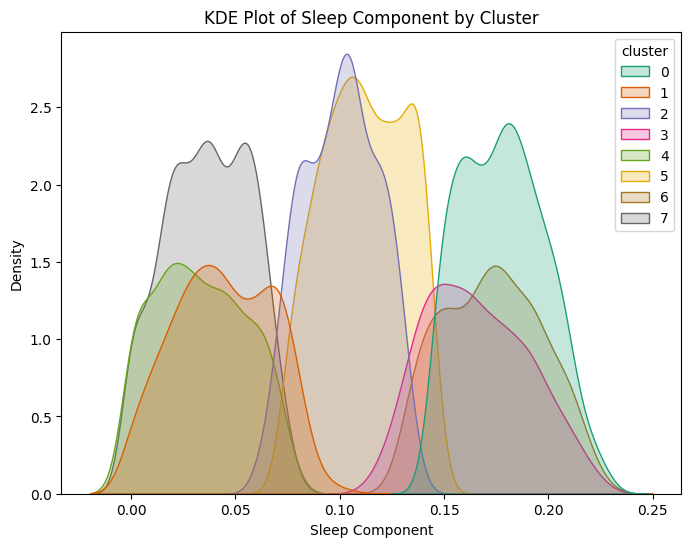

In [36]:
def plot_kde_by_cluster(dataframe, cluster_column, feature_columns):
    """
    Plots KDE plots for specified features, grouped by cluster.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        cluster_column (str): The name of the cluster column.
        feature_columns (list of str): A list of feature column names to plot.
    """

    for feature in feature_columns:
        plt.figure(figsize=(8, 6))  # Adjust figure size as needed
        sns.kdeplot(data=dataframe, x=feature, hue=cluster_column, fill=True, palette='Dark2')
        plt.title(f'KDE Plot of {feature} by Cluster')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.show()


# Specify the cluster column and feature columns to plot
cluster_column = 'cluster'
feature_columns = ['Performance Component', 'Stress Component', 'Sleep Component']

# Call the function to plot the KDE plots
plot_kde_by_cluster(df_sleep_stress_scores_nmf_cluster, cluster_column, feature_columns)

In [37]:
original_df_clustered = df_preprocessed.copy()
original_df_clustered['cluster'] = clusters

In [38]:
cluster_order = df_grouped['Performance Component'].mean().sort_values(ascending=False).index
df_grouped['Performance Component'].mean().sort_values(ascending=False)

cluster
1    0.106920
3    0.093414
7    0.077918
5    0.071387
2    0.065401
0    0.063967
4    0.059113
6    0.041678
Name: Performance Component, dtype: float64

In [39]:
print("Original table clustered, high performance clusters to low performance clusters")
original_df_clustered.groupby('cluster').mean().reindex(cluster_order)

Original table clustered, high performance clusters to low performance clusters


Gender       Age  Attendance (%)  Midterm_Score  Final_Score  \
cluster                                                                   
1        0.499037  0.514451        0.500241       0.637305     0.713020   
3        0.525105  0.500000        0.487076       0.668685     0.660441   
7        0.484006  0.489105        0.516269       0.511271     0.529673   
5        0.511323  0.520262        0.517566       0.491815     0.489903   
2        0.487535  0.523084        0.520877       0.502472     0.450525   
0        0.443198  0.504208        0.486133       0.490039     0.441982   
4        0.492986  0.499666        0.526351       0.358825     0.405009   
6        0.485323  0.508154        0.507694       0.403550     0.295042   

         Assignments_Avg  Quizzes_Avg  Participation_Score  Projects_Score  \
cluster                                                                      
1               0.499937     0.508181             0.509042        0.491985   
3               0.499064     0.495294             0.482054        0.484606   
7               0.489318     0.504172             0.488075        0.495958   
5               0.496153     0.489691             0.500857        0.496533   
2               0.512180     0.492678             0.500881        0.500149   
0               0.489140     0.503462             0.489543        0.503934   
4               0.470027     0.491901             0.510908        0.508857   
6               0.512041     0.504057             0.506123        0.503886   

         Total_Score  Study_Hours_per_Week  Extracurricular_Activities  \
cluster                                                                  
1           0.637803              0.509973                    0.319846   
3           0.679590              0.499197                    0.286611   
7           0.467856              0.514298                    0.292072   
5           0.498301              0.513654                    0.311085   
2           0.450938              0.503712                    0.308864   
0           0.537879              0.501700                    0.305750   
4           0.355030              0.492160                    0.306613   
6           0.420969              0.510301                    0.272016   

         Internet_Access_at_Home  Family_Income_Level  Stress_Level (1-10)  \
cluster                                                                      
1                       0.899807             0.410405             0.287519   
3                       0.884937             0.380753             0.750116   
7                       0.905424             0.424896             0.807294   
5                       0.896305             0.401669             0.229771   
2                       0.898892             0.422438             0.777470   
0                       0.903226             0.404628             0.200561   
4                       0.873747             0.392786             0.226230   
6                       0.906067             0.398239             0.765384   

         Sleep_Hours_per_Night  Business        CS  Engineering  Mathematics  
cluster                                                                       
1                     0.201580  0.202312  0.394990     0.300578     0.102119  
3                     0.787238  0.209205  0.422594     0.276151     0.092050  
7                     0.168957  0.194715  0.433936     0.271210     0.100139  
5                     0.528439  0.189511  0.400477     0.318236     0.091776  
2                     0.476953  0.207756  0.386427     0.301939     0.103878  
0                     0.843787  0.207574  0.396914     0.291725     0.103787  
4                     0.154870  0.194389  0.406814     0.306613     0.092184  
6                     0.820196  0.209393  0.395303     0.273973     0.121331

Looking back at the original dataset, we see all the high performers also have good attendance, while the struggling students are a mixed back of attendance rates (think slackers vs people trying hard but struggling). Unsurprisingly, our high performance component capture groups that tended to do well across the board on tests, but surprisingly the assignments were a mixed bag. This could make the case that assignments are more helpful as a learning tool than a measure of a students ability. Otherwise, I'd say the other variables have a fairly symmetrical distribution (there are groups with high attendance and low attendance in all levels, high and low income level, etc.) The only notable group is that our highest performers have the highest extracurricular activites.


## Conclusion

This was a super fun and interesting dataset, that despite some suspicious rows, had some overall trends that made sense and were interesting to pick up. By first dropping irrelevant rows for my analysis, cleaning the data, and normalizing our data, I enabled the NMF algorithm to do a good job of picking up interesting components for my analysis. The results of my analysis shed light on 8 interesting, distinct groups of students (although they certainly did have some overlap, which we expect since sleep, stress, and performance are continuous intervals.)

I found groups of students that were distinct by their stress, sleep, and performance. Each one of these groups has unique traits that educational programs could tailor their treatment too. For example, the high performers who clearly have busy schedules could be awarded with programs to help ease stress, while some of our slackers could be targeted by motivational campaigns to encourage their attendance and increased work (even if it adds some stress).

Thanks for checking out this project! I hope you enjoyed it as well!